In [ ]:
# %%bash
# pip install lightfm

In [ ]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from sklearn import model_selection
from scipy.sparse import coo_matrix
from scipy import sparse
from time import time
import matplotlib.pyplot as plt
import csv

import numpy as np
import pandas as pd

# from google.colab import files

## Util

In [ ]:
def downloadCSVFile(listOfDicts, fileName):
    resultDF = pd.DataFrame(listOfDicts)
    resultDF.to_csv(fileName)
#   files.download(fileName)

##Get Data

In [3]:
# %%bash
# mkdir -p 'results'

# rm ratings.csv

In [4]:
# # Upload ratings.csv

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

### Make Train, Validate, Test

In [17]:
ratingsDataPath = 'data-medium/ratings_5550689.csv'
# ratingsDataPath = 'data-medium/ratings_1387672.csv'
# ratingsDataPath = 'ml-latest-small/ratings.csv'

ratingsDF = pd.read_csv(ratingsDataPath)
ratingsDF = ratingsDF[['userId', 'movieId', 'rating']]

print('We have {} ratings total'.format(len(ratingsDF)))

# Alter ratings to work better for our model
ratingsDF['rating'] = ratingsDF['rating'].apply(lambda x: x - 2.9)

userIds = ratingsDF['userId'].unique().astype('int32')
movieIds = ratingsDF['movieId'].unique().astype('int32')

print('We have {} users'.format(len(userIds)))
print('We have {} movies'.format(len(movieIds)))

movieIdToIndex = {}
for index, movieId in enumerate(movieIds):
    movieIdToIndex[movieId] = index

userIdToIndex = {}
for index, userId in enumerate(userIds):
    userIdToIndex[userId] = index

ratingsTrainDF, ratingsTestDF = model_selection.train_test_split(ratingsDF, test_size=0.2, random_state=324)
ratingsTrainGridSearchDF, ratingsValidateGridSearchDF = model_selection.train_test_split(ratingsTrainDF, test_size=0.2, random_state=773)

print('We have {} train ratings'.format(len(ratingsTrainDF)))
print('We have {} test ratings'.format(len(ratingsTestDF)))
print('We have {} grid search train ratings'.format(len(ratingsTrainGridSearchDF)))
print('We have {} grid search validate ratings'.format(len(ratingsValidateGridSearchDF)))


We have 5550689 ratings total
We have 264073 users
We have 36681 movies
We have 4440551 train ratings
We have 1110138 test ratings
We have 3552440 grid search train ratings
We have 888111 grid search validate ratings


In [18]:
ratingsTrainDF.head()

,userId,movieId,rating
4811390,138938,590,-1.9
958640,265521,381,-0.9
140550,20432,5349,0.6
932529,280782,8784,2.1
934736,108844,4369,-1.9


### Convert to Matrix

In [19]:
def ratingsDFToUserMovieMatrix(ratingsDF, userIdToIndex, movieIdToIndex):
    numUsers = len(userIdToIndex)
    numMovies = len(movieIdToIndex)
    
#     startTime = time()
#     mat = sparse.coo_matrix((ratingsDF["rating"], (ratingsDF["userId"], ratingsDF["movieId"])))
#     result1 = mat
#     totalTime = time() - startTime
#     print('Method 1 takes {} seconds'.format(totalTime))
#     print(result1.todense())
#     print('Shape: {}'.format(result1.shape))
#     print('')

#     startTime = time()
#     ratingsDF2 = ratingsDF.copy()
#     numRatings = len(ratingsDF)
#     usersInDF = set(ratingsDF['userId'])
#     for user in userIds:
#         if user not in usersInDF:
#             ratingsDF2.loc[numRatings] = 0
#             numRatings += 1
#     moviesInDF = set(ratingsDF['movieId'])
#     for movie in movieIds:
#         if movie not in moviesInDF:
#             ratingsDF2.loc[numRatings] = 0
#             numRatings += 1
        
#     userItemDF = ratingsDF2.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)#.fillna(0)
#     result2 = coo_matrix(userItemDF.values)
#     totalTime = time() - startTime
#     print('Method 2 takes {} seconds'.format(totalTime))
#     print(result2.todense())
#     print('Shape: {}'.format(result2.shape))
#     print('')

    startTime = time()
    userMovieMatrix = np.zeros((numUsers, numMovies))
    for index, row in ratingsDF.iterrows():
        userId = int(row['userId'])
        movieId = int(row['movieId'])
        rating = float(row['rating'])

        userIndex = userIdToIndex[userId]
        movieIndex = movieIdToIndex[movieId]
        userMovieMatrix[userIndex, movieIndex] = rating
    result3 = sparse.coo_matrix(userMovieMatrix)
    totalTime = time() - startTime
    print('')
    print('Method 3 takes {} seconds'.format(totalTime))
        
#     print('Method 1 and 2: {}'.format(result1 == result2))
#     print('Method 2 and 3: {}'.format(result2 == result3))
    
    return result3


#     return coo_matrix(userMovieMatrix)


XTrain = ratingsDFToUserMovieMatrix(ratingsTrainGridSearchDF, userIdToIndex, movieIdToIndex)
print('Shape of X Train: {}'.format(XTrain.shape))
XValidate = ratingsDFToUserMovieMatrix(ratingsValidateGridSearchDF, userIdToIndex, movieIdToIndex)
print('Shape of X Validate: {}'.format(XValidate.shape))
XTest = ratingsDFToUserMovieMatrix(ratingsTestDF, userIdToIndex, movieIdToIndex)
print('Shape of X Test: {}'.format(XTest.shape))


Method 3 takes 442.3145561218262 seconds
Shape of X Train: (264073, 36681)

Method 3 takes 242.25914907455444 seconds
Shape of X Validate: (264073, 36681)

Method 3 takes 248.31665325164795 seconds
Shape of X Test: (264073, 36681)


# Add K-Fold Validation to Grid Search

# Run Grid Search

In [20]:
def runModel(params, XTrain, XTest):
    learningRate = params['learning_rate']
    lossFunction = params['loss']
    learning_schedule = params['learning_schedule']
  
    startTime = time()
  
    model = LightFM(
        learning_rate=learningRate, 
        loss=lossFunction, 
        learning_schedule=learning_schedule, 
        random_state=8362
    )
    model.fit(XTrain, epochs=5)

    totalTime = time() - startTime

    # Evaluate the trained model
    #   test_precision = precision_at_k(model, XTest, k=10).mean()
    #   test_recall = recall_at_k(model, XTest, k=10).mean()
    train_auc = auc_score(model, XTrain).mean()
    test_auc = auc_score(model, XTest).mean()

    return train_auc, test_auc, totalTime

In [21]:
gridSearchParams = {
    'learning_rate': [0.05],
    'loss': ['logistic', 'bpr', 'warp', 'warp-kos'],
#     'loss': ['bpr'],
    'learning_schedule': ['adagrad', 'adadelta'],
}

def gridSearch(gridSearchParams):
  
    results = []
  
    for learningRate in gridSearchParams['learning_rate']:
        for lossFunction in gridSearchParams['loss']:
            for learning_schedule in gridSearchParams['learning_schedule']:
                params = {
                    'learning_rate': learningRate,
                    'loss': lossFunction,
                    'learning_schedule': learning_schedule,
                }
                print('Running for params: {}'.format(params))
                train_auc, test_auc, totalTime = runModel(params, XTrain, XValidate)
                params['train_auc'] = train_auc
                params['test_auc'] = test_auc
                params['time'] = totalTime
                results.append(params)
        
    print(results)
    downloadCSVFile(results, 'gridSearchResults.csv')
    return results

In [22]:
startTime = time()

gridSearchResults = gridSearch(gridSearchParams)

totalTime = time() - startTime
if totalTime > 60:
    print('Total time: {:0.2f} minutes'.format(totalTime / 60))
else:
    print('Total time: {:0.2f} seconds'.format(totalTime))

[{'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adagrad', 'train_auc': 0.9097353, 'test_auc': 0.9121717, 'time': 14.600603103637695}, {'learning_rate': 0.05, 'loss': 'logistic', 'learning_schedule': 'adadelta', 'train_auc': 0.89828676, 'test_auc': 0.9028818, 'time': 17.27854013442993}, {'learning_rate': 0.05, 'loss': 'bpr', 'learning_schedule': 'adagrad', 'train_auc': 0.8617787, 'test_auc': 0.8268794, 'time': 19.842493772506714}, {'learning_rate': 0.05, 'loss': 'bpr', 'learning_schedule': 'adadelta', 'train_auc': 0.9205199, 'test_auc': 0.8903531, 'time': 21.551750898361206}, {'learning_rate': 0.05, 'loss': 'warp', 'learning_schedule': 'adagrad', 'train_auc': 0.9823055, 'test_auc': 0.9764522, 'time': 19.677732944488525}, {'learning_rate': 0.05, 'loss': 'warp', 'learning_schedule': 'adadelta', 'train_auc': 0.9775266, 'test_auc': 0.97565055, 'time': 19.082769870758057}, {'learning_rate': 0.05, 'loss': 'warp-kos', 'learning_schedule': 'adagrad', 'train_auc': 0.9801739, '

In [27]:
def extractBestParams(gridSearchResults):
    bestIndex = 0
    bestAUC = gridSearchResults[0]['test_auc']

    for index, results in enumerate(gridSearchResults):
        if results['test_auc'] > bestAUC:
            bestAUC = results['test_auc']
            bestIndex = index

    bestParams = {}
    for param, value in gridSearchResults[bestIndex].items():
        if param in ['train_auc', 'test_auc', 'time']:
            continue
        bestParams[param] = value

    print('Best AUC is: {}'.format(bestAUC))
    return bestParams

bestParams = extractBestParams(gridSearchResults)
bestParams

Best AUC is: 0.9764521718025208


{'learning_rate': 0.05, 'learning_schedule': 'adagrad', 'loss': 'warp'}

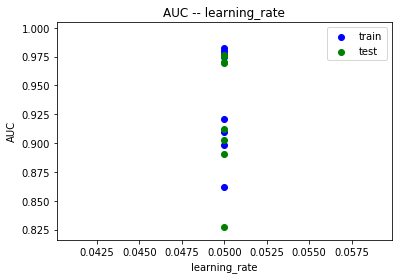

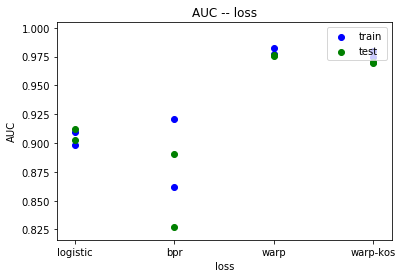

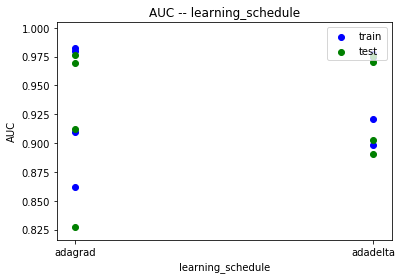

In [28]:
def plotGridSearchResults(gridSearchResults):
    gridSearchDF = pd.DataFrame(gridSearchResults)
    for param in gridSearchParams.keys():
        plt.scatter(gridSearchDF[param], gridSearchDF['train_auc'], color='blue')
        plt.scatter(gridSearchDF[param], gridSearchDF['test_auc'], color='green')
        plt.title('AUC -- {}'.format(param))
        plt.ylabel('AUC')
        plt.xlabel(param)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

plotGridSearchResults(gridSearchResults)

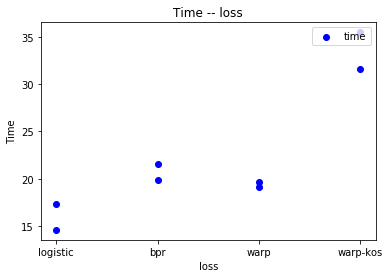

In [29]:
def plotGridSearchTime(gridSearchResults):
    gridSearchDF = pd.DataFrame(gridSearchResults)
    plt.scatter(gridSearchDF['loss'], gridSearchDF['time'], color='blue')
    plt.title('Time -- {}'.format('loss'))
    plt.ylabel('Time')
    plt.xlabel('loss')
    plt.legend(['time'], loc='upper right')
    plt.show()

plotGridSearchTime(gridSearchResults)

# Find Best # of Epochs

Write code to check best score in each epoch and then return the best score, not the last score

# Sampling Amount of Data

In [30]:
dataFractions = np.arange(0.2, 1.2, 0.2)
numRatings = len(ratingsTrainDF)
dataSizes = [int(fraction * numRatings) for fraction in dataFractions]
dataSizes

[888110, 1776220, 2664330, 3552440, 4440551]

In [31]:
def sizeSamplingSearch(dataSizes):
    sizeSamplingResults = []

    for numRatings in dataSizes:
        print('')
        print('Running for size: {}'.format(numRatings))
        ratingsTrainDFSampled = ratingsTrainDF.sample(n=numRatings)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndex)
        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XValidate)
        result = {
            'numRatings': numRatings,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        sizeSamplingResults.append(result)

    return sizeSamplingResults

In [32]:
sizeSamplingResults = sizeSamplingSearch(dataSizes)


Running for size: 888110

Method 3 takes 254.61199021339417 seconds
Running for size: 1776220

Method 3 takes 295.8291528224945 seconds
Running for size: 2664330

Method 3 takes 359.85819911956787 seconds
Running for size: 3552440

Method 3 takes 414.149365901947 seconds
Running for size: 4440551

Method 3 takes 454.96837306022644 seconds


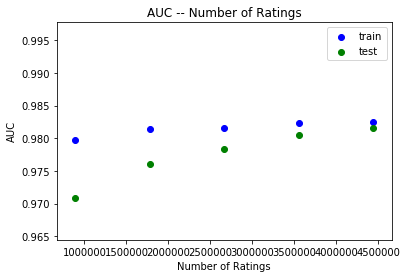

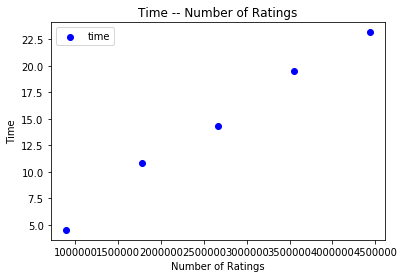

In [33]:
def plotSizeSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Ratings')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numRatings'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Ratings')
    plt.legend(['time'], loc='upper left')
    plt.show()

plotSizeSamplingResults(sizeSamplingResults)

# Sample By Number of Users

In [34]:
userFractions = np.arange(0.2, 1.2, 0.2)
numUsers = len(userIds)
userSizes = [int(fraction * numUsers) for fraction in userFractions]
userSizes

[52814, 105629, 158443, 211258, 264073]

In [35]:
def userSamplingSearch(userSizes):
    userSamplingResults = []

    for numUsers in userSizes:
        print('Running for size: {}'.format(numUsers))
        sampledUserIds = np.random.choice(userIds, numUsers, replace=False)
        userIdToIndexSampled = {}
        for index, userId in enumerate(sampledUserIds):
            userIdToIndexSampled[userId] = index

        ratingsDFSampled = ratingsDF[ratingsDF['userId'].isin(sampledUserIds)]

        ratingsTrainDFSampled, ratingsTestDFSampled = model_selection.train_test_split(ratingsDFSampled, test_size=0.2, random_state=3339)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndexSampled, movieIdToIndex)
        XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndexSampled, movieIdToIndex)

        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest)
        result = {
            'numUsers': numUsers,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        userSamplingResults.append(result)

    return userSamplingResults

In [36]:
userSamplingResults = userSamplingSearch(userSizes)
userSamplingResults

Running for size: 52814

Method 3 takes 92.17588710784912 seconds

Method 3 takes 43.04564309120178 seconds
Running for size: 105629

Method 3 takes 186.30177807807922 seconds

Method 3 takes 90.57673692703247 seconds
Running for size: 158443

Method 3 takes 254.37595796585083 seconds

Method 3 takes 134.1620490550995 seconds
Running for size: 211258

Method 3 takes 341.7265028953552 seconds

Method 3 takes 182.2391550540924 seconds
Running for size: 264073

Method 3 takes 429.9994351863861 seconds

Method 3 takes 229.4788212776184 seconds


[{'numUsers': 52814,
  'test_auc': 0.9730921,
  'time': 4.332552194595337,
  'train_auc': 0.97995806},
 {'numUsers': 105629,
  'test_auc': 0.9757785,
  'time': 8.033267974853516,
  'train_auc': 0.98138386},
 {'numUsers': 158443,
  'test_auc': 0.9770667,
  'time': 13.390747308731079,
  'train_auc': 0.9823217},
 {'numUsers': 211258,
  'test_auc': 0.97720516,
  'time': 16.884137868881226,
  'train_auc': 0.9822111},
 {'numUsers': 264073,
  'test_auc': 0.97724766,
  'time': 23.47303605079651,
  'train_auc': 0.98257786}]

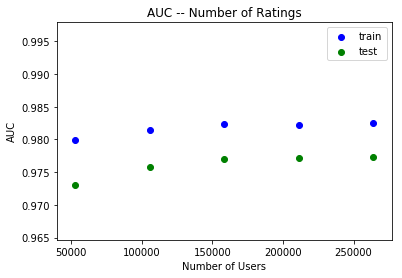

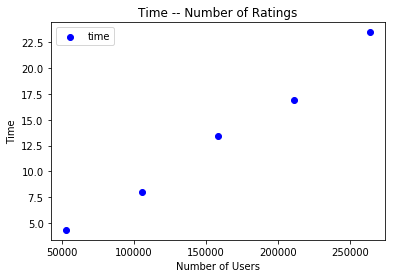

In [37]:
def plotUserSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Users')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numUsers'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Users')
    plt.legend( ['time'], loc='upper left')
    plt.show()

plotUserSamplingResults(userSamplingResults)

# Sample By Number of Movies

In [38]:
movieFractions = np.arange(0.2, 1.2, 0.2)
numMovies = len(movieIds)
movieSizes = [int(fraction * numMovies) for fraction in movieFractions]
movieSizes

[7336, 14672, 22008, 29344, 36681]

In [39]:
def movieSamplingSearch(movieSizes):
    movieSamplingResults = []

    for numMovies in movieSizes:
        print('Running for size: {}'.format(numMovies))
        sampledMovieIds = np.random.choice(movieIds, numMovies, replace=False)
        movieIdToIndexSampled = {}
        for index, movieId in enumerate(sampledMovieIds):
            movieIdToIndexSampled[movieId] = index

        ratingsDFSampled = ratingsDF[ratingsDF['movieId'].isin(sampledMovieIds)]

        ratingsTrainDFSampled, ratingsTestDFSampled = model_selection.train_test_split(ratingsDFSampled, test_size=0.2, random_state=3339)
        XTrain = ratingsDFToUserMovieMatrix(ratingsTrainDFSampled, userIdToIndex, movieIdToIndexSampled)
        XTest = ratingsDFToUserMovieMatrix(ratingsTestDFSampled, userIdToIndex, movieIdToIndexSampled)

        train_auc, test_auc, totalTime = runModel(bestParams, XTrain, XTest)
        result = {
            'numMovie': numMovies,
            'train_auc': train_auc,
            'test_auc': test_auc,
            'time': totalTime,
        }
        movieSamplingResults.append(result)

    return movieSamplingResults

In [40]:
movieSamplingResults = movieSamplingSearch(movieSizes)
movieSamplingResults

Running for size: 7336

Method 3 takes 87.70529198646545 seconds

Method 3 takes 42.72982883453369 seconds
Running for size: 14672

Method 3 takes 180.3420069217682 seconds

Method 3 takes 89.70879101753235 seconds
Running for size: 22008

Method 3 takes 265.4581730365753 seconds

Method 3 takes 137.03178095817566 seconds
Running for size: 29344

Method 3 takes 365.76418113708496 seconds

Method 3 takes 186.99759006500244 seconds
Running for size: 36681

Method 3 takes 458.37916803359985 seconds

Method 3 takes 233.05004787445068 seconds


[{'numMovie': 7336,
  'test_auc': 0.9715266,
  'time': 3.49863600730896,
  'train_auc': 0.983168},
 {'numMovie': 14672,
  'test_auc': 0.9755961,
  'time': 8.252760887145996,
  'train_auc': 0.9834842},
 {'numMovie': 22008,
  'test_auc': 0.97611034,
  'time': 12.028514862060547,
  'train_auc': 0.9828501},
 {'numMovie': 29344,
  'test_auc': 0.97701144,
  'time': 18.1020290851593,
  'train_auc': 0.9827862},
 {'numMovie': 36681,
  'test_auc': 0.9773803,
  'time': 22.88926386833191,
  'train_auc': 0.9825712}]

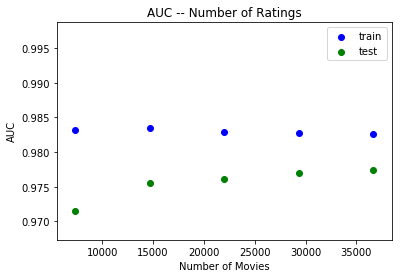

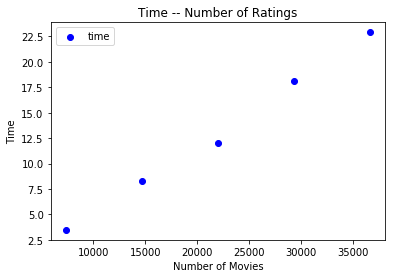

In [41]:
def plotMovieSamplingResults(sizeSamplingResults):
    sizeSamplingDF = pd.DataFrame(sizeSamplingResults)

    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['train_auc'], color='blue')
    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['test_auc'], color='green')
    plt.title('AUC -- Number of Ratings')
    plt.ylabel('AUC')
    plt.xlabel('Number of Movies')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    plt.scatter(sizeSamplingDF['numMovie'], sizeSamplingDF['time'], color='blue')
    plt.title('Time -- Number of Ratings')
    plt.ylabel('Time')
    plt.xlabel('Number of Movies')
    plt.legend( ['time'], loc='upper left')
    plt.show()

plotMovieSamplingResults(movieSamplingResults)